In [5]:
import os
import glob
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.tensorboard import SummaryWriter

# -----------------------------
# 1. Mount Google Drive
# -----------------------------
from google.colab import drive
drive.mount('/content/drive')

# -----------------------------
# 2. Đặt đường dẫn tới 4 folder
# -----------------------------
BASE           = '/content/drive/MyDrive'
TRAIN_IMG_DIR  = os.path.join(BASE, 'Training_Data')
TRAIN_MASK_DIR = os.path.join(BASE, 'Training_GroundTruth')
VAL_IMG_DIR    = os.path.join(BASE, 'Test_Data')
VAL_MASK_DIR   = os.path.join(BASE, 'Test_GroundTruth')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# -----------------------------
# 3. Dataset & Transforms
# -----------------------------
class ISICDataset(Dataset):
    def __init__(self, pairs, transforms=None):
        self.pairs = pairs
        self.transforms = transforms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 127).astype('float32')
        if self.transforms:
            aug = self.transforms(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        return img, mask.unsqueeze(0)

def make_pairs(img_dir, mask_dir):
    if not os.path.exists(img_dir):
        raise ValueError(f"Directory not found: {img_dir}")
    if not os.path.exists(mask_dir):
        raise ValueError(f"Directory not found: {mask_dir}")
    img_paths = sorted(glob.glob(os.path.join(img_dir, '*')))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*')))
    if len(img_paths) != len(mask_paths):
        raise ValueError("Image and mask count mismatch.")
    print(f"Paired {len(img_paths)} samples")
    return list(zip(img_paths, mask_paths))

train_transforms = A.Compose([
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.Affine(translate_percent={'x':(-0.05,0.05),'y':(-0.05,0.05)}, scale=(0.95,1.05), rotate=0, p=0.5),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2(),
])
val_transforms = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ToTensorV2(),
])

train_ds = ISICDataset(make_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR), transforms=train_transforms)
val_ds   = ISICDataset(make_pairs(VAL_IMG_DIR,   VAL_MASK_DIR),   transforms=val_transforms)

print("Train samples:", len(train_ds))
print("Val samples:  ", len(val_ds))

BATCH_SIZE = 4
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=1,           shuffle=False, num_workers=2)

# -----------------------------
# 4. Model, Loss, Optimizer
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[-1]     = nn.Conv2d(256, 1, kernel_size=1)
model.aux_classifier[-1] = nn.Conv2d(256, 1, kernel_size=1)
model = model.to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, inputs, targets):
        bce = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt  = torch.exp(-bce)
        return (self.alpha * (1 - pt) ** self.gamma * bce).mean()

focal_loss = FocalLoss()
def dice_score(pred, target, smooth=1e-6):
    p = torch.sigmoid(pred).view(-1)
    t = target.view(-1)
    inter = (p * t).sum()
    return (2*inter + smooth) / (p.sum() + t.sum() + smooth)
def metrics(pred, mask):
    pred, mask = pred.view(-1), mask.view(-1)
    TP = (pred * mask).sum().item()
    FP = (pred * (1-mask)).sum().item()
    FN = ((1-pred) * mask).sum().item()
    prec = TP / (TP+FP+1e-6)
    rec  = TP / (TP+FN+1e-6)
    f1   = 2*prec*rec / (prec+rec+1e-6)
    return prec, rec, f1

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
writer    = SummaryWriter(log_dir='runs/ISIC_DeepLabV3')

# -----------------------------
# 5. Training Loop + Logging
# -----------------------------
EPOCHS, patience = 20, 5
best_val_loss, p_counter = float('inf'), 0

train_losses, val_losses = [], []
epoch_ious, epoch_dices = [], []
epoch_precs, epoch_recs, epoch_f1s = [], [], []

for epoch in range(1, EPOCHS+1):
    # Train
    model.train()
    tloss = 0
    for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch} Train"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        out = model(imgs)['out']
        loss = 0.5*focal_loss(out, masks) + 0.5*(1-dice_score(out, masks))
        loss.backward()
        optimizer.step()
        tloss += loss.item()
    avg_t = tloss / len(train_loader)
    train_losses.append(avg_t)
    writer.add_scalar('Train/Loss', avg_t, epoch)

    # Validate
    model.eval()
    vloss = 0
    iou_l, dice_l, p_l, r_l, f1_l = [], [], [], [], []
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="Validate"):
            imgs, masks = imgs.to(device), masks.to(device)
            out = model(imgs)['out']
            vloss += (0.5*focal_loss(out, masks) + 0.5*(1-dice_score(out, masks))).item()

            prob = torch.sigmoid(out)
            pred = (prob>0.5).float()
            inter = (pred*masks).sum((1,2,3))
            union = pred.sum((1,2,3)) + masks.sum((1,2,3)) - inter
            iou_l.append(((inter+1e-6)/(union+1e-6)).item())
            dice_l.append(dice_score(out, masks).item())
            p_, r_, f1_ = metrics(pred, masks)
            p_l.append(p_); r_l.append(r_); f1_l.append(f1_)

    avg_v = vloss / len(val_loader)
    val_losses.append(avg_v)
    epoch_ious.append(np.mean(iou_l))
    epoch_dices.append(np.mean(dice_l))
    epoch_precs.append(np.mean(p_l))
    epoch_recs.append(np.mean(r_l))
    epoch_f1s.append(np.mean(f1_l))

    writer.add_scalar('Val/Loss', epoch_losses[-1] if False else avg_v, epoch)
    writer.add_scalar('Val/IoU', epoch_ious[-1], epoch)
    writer.add_scalar('Val/Dice', epoch_dices[-1], epoch)
    writer.add_scalar('Val/Precision', epoch_precs[-1], epoch)
    writer.add_scalar('Val/Recall', epoch_recs[-1], epoch)
    writer.add_scalar('Val/F1', epoch_f1s[-1], epoch)

    print(f"Epoch {epoch} | Train Loss: {avg_t:.4f} | Val Loss: {avg_v:.4f}")
    print(f"    IoU: {epoch_ious[-1]:.4f} | Dice: {epoch_dices[-1]:.4f} | "
          f"Prec: {epoch_precs[-1]:.4f} | Rec: {epoch_recs[-1]:.4f} | F1: {epoch_f1s[-1]:.4f}")

    if avg_v < best_val_loss:
        best_val_loss = avg_v
        p_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        p_counter += 1
        if p_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    scheduler.step()


Paired 900 samples
Paired 379 samples
Train samples: 900
Val samples:   379


Validate: 100%|██████████| 379/379 [03:01<00:00,  2.09it/s]


Epoch 1 | Train Loss: 0.1814 | Val Loss: 0.1554
    IoU: 0.8103 | Dice: 0.7391 | Prec: 0.8614 | Rec: 0.9365 | F1: 0.8856


Validate: 100%|██████████| 379/379 [00:50<00:00,  7.57it/s]


Epoch 2 | Train Loss: 0.1297 | Val Loss: 0.1351
    IoU: 0.8199 | Dice: 0.7884 | Prec: 0.9111 | Rec: 0.8889 | F1: 0.8876


Validate: 100%|██████████| 379/379 [00:50<00:00,  7.48it/s]


Epoch 3 | Train Loss: 0.1152 | Val Loss: 0.1333
    IoU: 0.8254 | Dice: 0.8118 | Prec: 0.8956 | Rec: 0.9265 | F1: 0.8931


Validate: 100%|██████████| 379/379 [00:50<00:00,  7.57it/s]


Epoch 4 | Train Loss: 0.0954 | Val Loss: 0.1200
    IoU: 0.8166 | Dice: 0.8201 | Prec: 0.8806 | Rec: 0.9312 | F1: 0.8856


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.71it/s]


Epoch 5 | Train Loss: 0.0897 | Val Loss: 0.1104
    IoU: 0.8324 | Dice: 0.8308 | Prec: 0.9018 | Rec: 0.9253 | F1: 0.9013


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.74it/s]


Epoch 6 | Train Loss: 0.0783 | Val Loss: 0.1048
    IoU: 0.8470 | Dice: 0.8496 | Prec: 0.9234 | Rec: 0.9205 | F1: 0.9104


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.60it/s]


Epoch 7 | Train Loss: 0.0718 | Val Loss: 0.0968
    IoU: 0.8500 | Dice: 0.8579 | Prec: 0.9114 | Rec: 0.9334 | F1: 0.9135


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.64it/s]


Epoch 8 | Train Loss: 0.0651 | Val Loss: 0.0883
    IoU: 0.8536 | Dice: 0.8738 | Prec: 0.9095 | Rec: 0.9390 | F1: 0.9154


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.78it/s]


Epoch 9 | Train Loss: 0.0617 | Val Loss: 0.0879
    IoU: 0.8588 | Dice: 0.8750 | Prec: 0.9276 | Rec: 0.9259 | F1: 0.9190


Validate: 100%|██████████| 379/379 [00:50<00:00,  7.56it/s]


Epoch 10 | Train Loss: 0.0593 | Val Loss: 0.0859
    IoU: 0.8593 | Dice: 0.8789 | Prec: 0.9353 | Rec: 0.9189 | F1: 0.9191


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.59it/s]


Epoch 11 | Train Loss: 0.0586 | Val Loss: 0.0889
    IoU: 0.8578 | Dice: 0.8757 | Prec: 0.9242 | Rec: 0.9282 | F1: 0.9181


Validate: 100%|██████████| 379/379 [00:49<00:00,  7.61it/s]


Epoch 12 | Train Loss: 0.0592 | Val Loss: 0.0913
    IoU: 0.8569 | Dice: 0.8725 | Prec: 0.9169 | Rec: 0.9367 | F1: 0.9178


Validate: 100%|██████████| 379/379 [00:48<00:00,  7.75it/s]


Epoch 13 | Train Loss: 0.0577 | Val Loss: 0.0857
    IoU: 0.8630 | Dice: 0.8805 | Prec: 0.9305 | Rec: 0.9275 | F1: 0.9215


Epoch 14 Train:  49%|████▉     | 110/225 [02:30<02:37,  1.37s/it]


KeyboardInterrupt: 

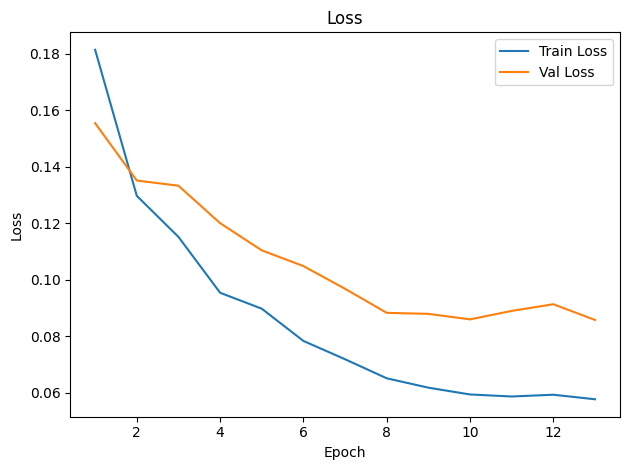

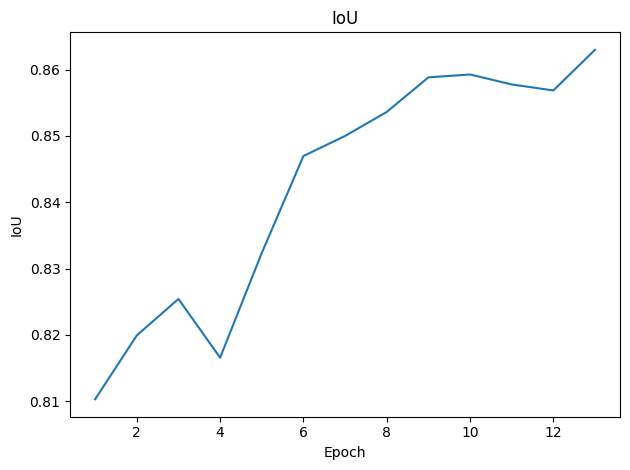

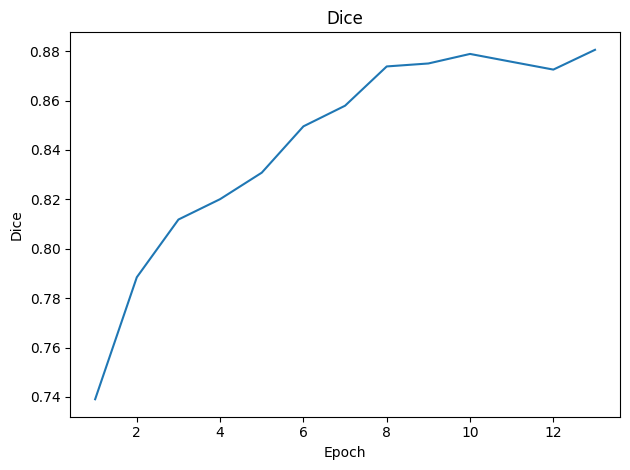

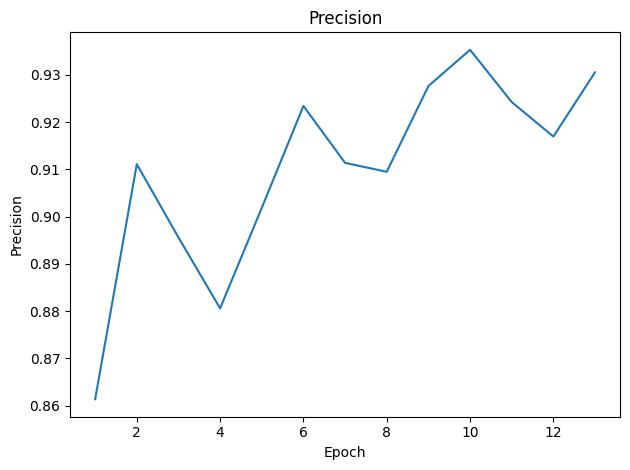

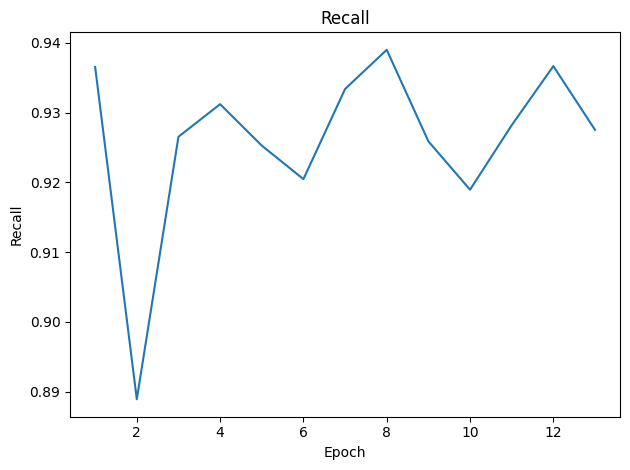

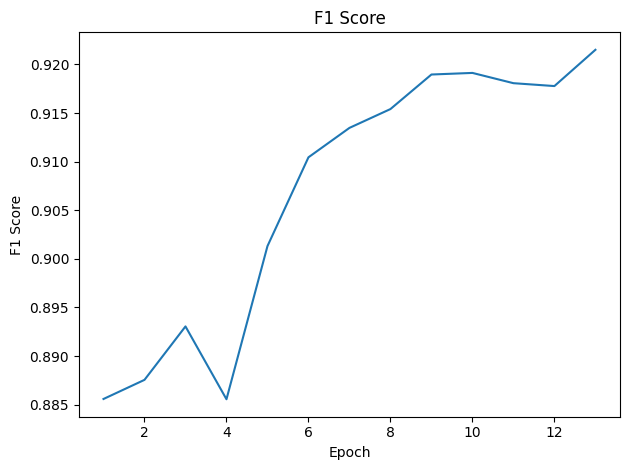

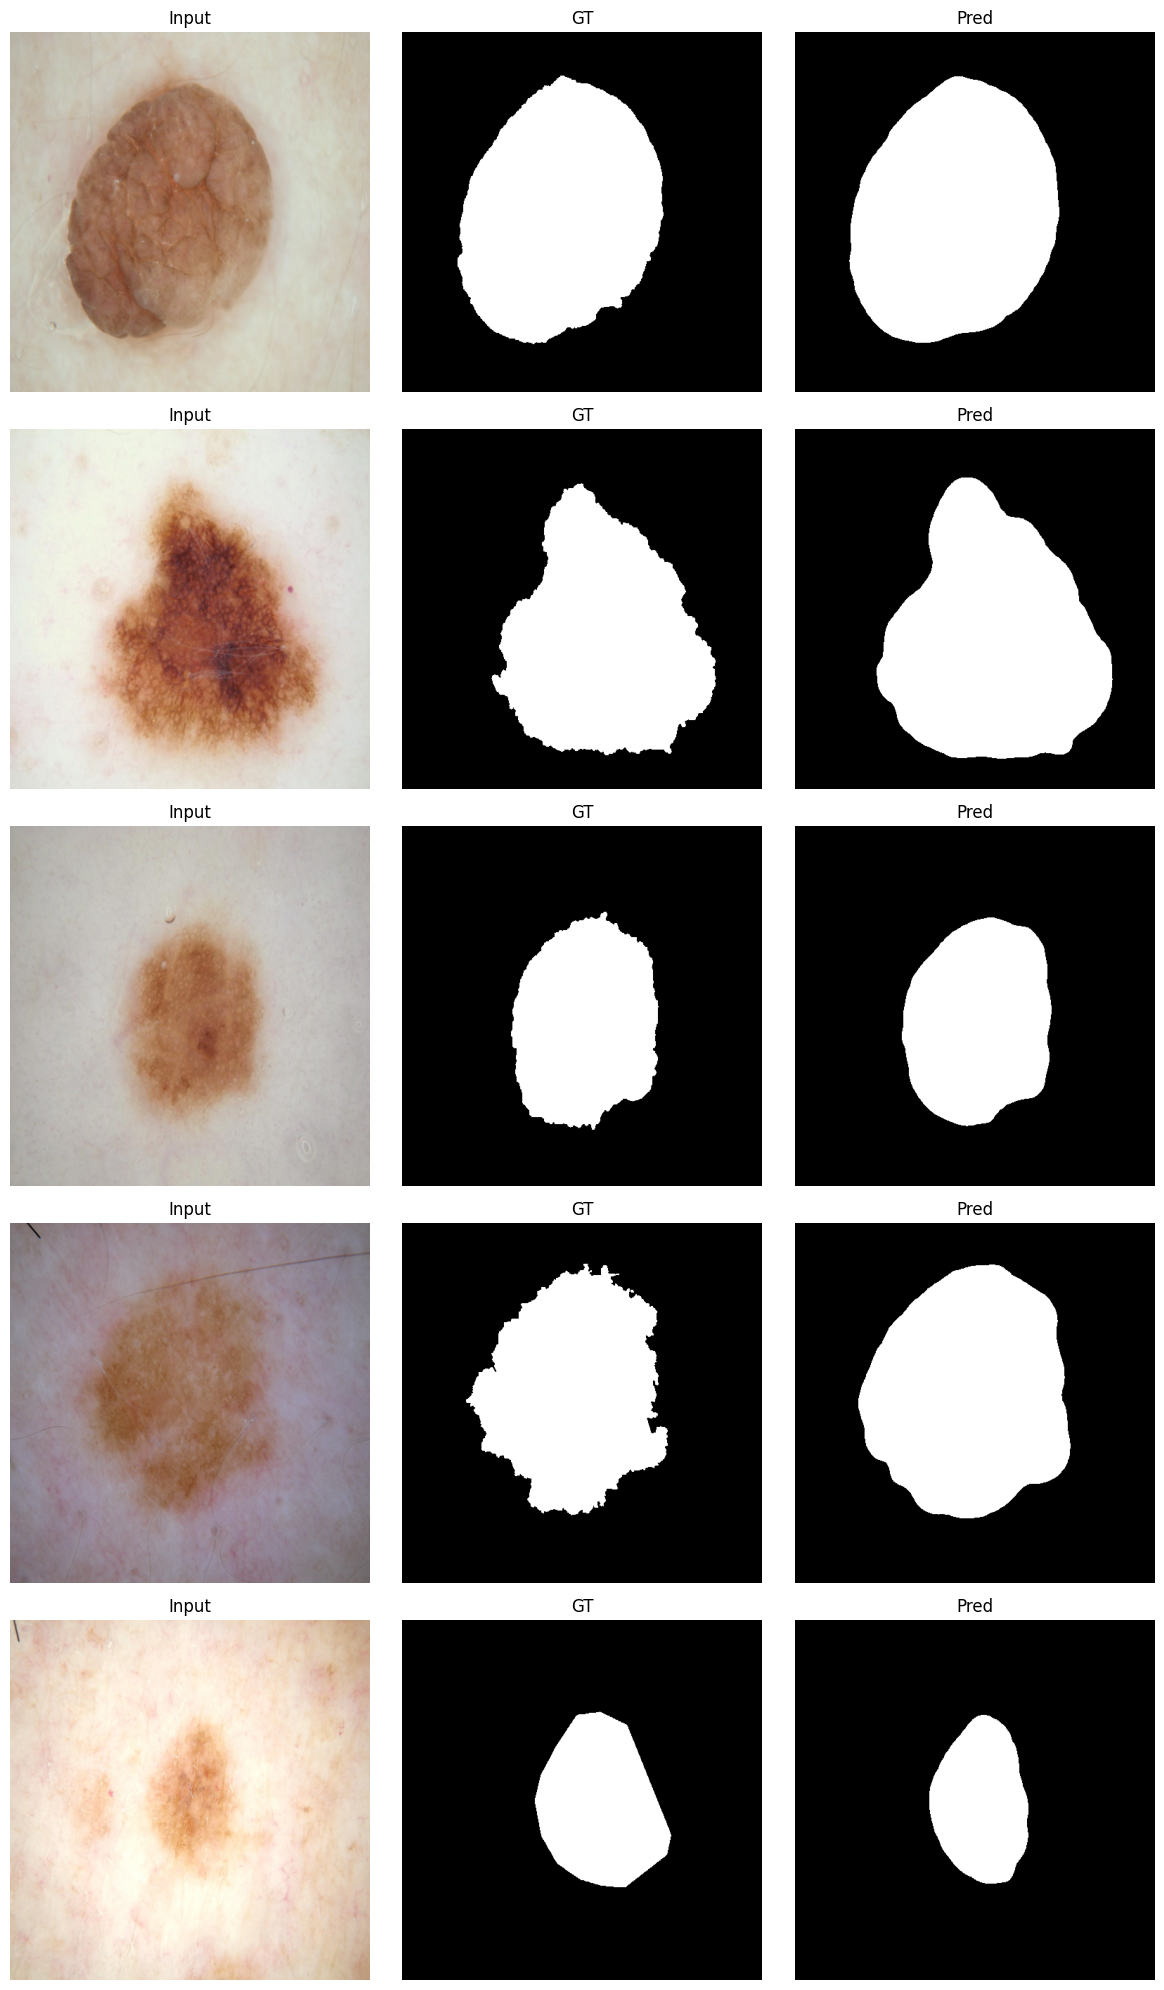

Hoàn tất.


In [7]:

# -----------------------------
# 6. Vẽ biểu đồ kết quả
# -----------------------------
epochs = list(range(1, len(train_losses)+1))

plt.figure(); plt.plot(epochs, train_losses, label='Train Loss'); plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_ious, label='IoU')
plt.xlabel('Epoch'); plt.ylabel('IoU'); plt.title('IoU'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_dices, label='Dice')
plt.xlabel('Epoch'); plt.ylabel('Dice'); plt.title('Dice'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_precs, label='Precision')
plt.xlabel('Epoch'); plt.ylabel('Precision'); plt.title('Precision'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_recs, label='Recall')
plt.xlabel('Epoch'); plt.ylabel('Recall'); plt.title('Recall'); plt.tight_layout(); plt.show()

plt.figure(); plt.plot(epochs, epoch_f1s, label='F1 Score')
plt.xlabel('Epoch'); plt.ylabel('F1 Score'); plt.title('F1 Score'); plt.tight_layout(); plt.show()

# -----------------------------
# 7. Hiển thị dự đoán mẫu
# -----------------------------
def denormalize(img, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    img = img.cpu().numpy().transpose(1,2,0)
    img = img * std + mean
    return np.clip(img,0,1)

def visualize_predictions(model, dataset, device, n=5):
    model.eval()
    idxs = random.sample(range(len(dataset)), n)
    fig, axs = plt.subplots(n,3, figsize=(12,4*n))
    with torch.no_grad():
        for i, idx in enumerate(idxs):
            img, mask = dataset[idx]
            out = torch.sigmoid(model(img.unsqueeze(0).to(device))['out'])[0,0].cpu().numpy()
            pred_mask = (out>0.5).astype(np.uint8)
            axs[i,0].imshow(denormalize(img)); axs[i,0].axis('off'); axs[i,0].set_title('Input')
            axs[i,1].imshow(mask[0].cpu(), cmap='gray'); axs[i,1].axis('off'); axs[i,1].set_title('GT')
            axs[i,2].imshow(pred_mask, cmap='gray'); axs[i,2].axis('off'); axs[i,2].set_title('Pred')
    plt.tight_layout(); plt.show()

visualize_predictions(model, val_ds, device, n=5)
print("Hoàn tất.")